##### Run this cell to set your notebook up on Google Colab

In [1]:
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!git clone https://github.com/yfletberliac/rlss2019-hands-on.git > /dev/null 2>&1
#!pip install -q torch==1.1.0 torchvision pyvirtualdisplay piglet > /dev/null 2>&1

# <font color='#ed7d31'>Deep Q Networks</font>
------------
You can find the original paper [here](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

## <font color='#ed7d31'>Preliminaries: Q Learning</font>

#### <font color='#ed7d31'>Q-Value</font>

**Q-Value** is a measure of the overall expected reward assuming the agent is in state $s$ and performs action $a$, and then continues playing until the end of the episode following some policy $\pi$. It is defined mathematically as:

\begin{equation}
Q^{\pi}\left(s_{t}, a_{t}\right)=E\left[R_{t+1}+\gamma R_{t+2}+\gamma^{2} R_{t+3}+\ldots | s_{t}, a_{t}\right]
\end{equation}

where $R_{t+1}$ is the immediate reward received after performing action $a_{t}$ in state $s_{t}$ and $\gamma$ is the discount factor and controls the importance of the future rewards versus the immediate ones: the lower the discount factor is, the less important future rewards are.

#### <font color='#ed7d31'>Bellman Optimality Equation</font>

Formally, the Bellman equation defines the relationships between a given state (or, in our case, a **state-action pair**) and its successors. While many forms exist, one of the most common is the **Bellman Optimality Equation** for the optimal **Q-Value**, which is given by:

\begin{equation}
Q^{*}(s, a)=\sum_{s^{\prime}, r} p\left(s^{\prime}, r | s, a\right)\left[r+\gamma \max _{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right)\right]
\end{equation}

Of course, when no uncertainty exists (transition probabilities are either 0 or 1), we have:

\begin{equation}
Q^{*}(s, a)=r(s, a)+\gamma \max _{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right)
\end{equation}

#### <font color='#ed7d31'>Q-Value Iteration</font>

We define the corresponding Bellman backup operator:
\begin{equation}
[\mathcal{T} Q]\left(s, a\right)=r(s, a)+\gamma \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)
\end{equation}

$Q$ is a fixed point of $\mathcal{T}$:
\begin{equation}
\mathcal{T} Q^{*}=Q^{*}
\end{equation}

If we apply the Bellman operator $\mathcal{T}$ repeatedly to any initial $Q$, the series converges to $Q^{*}$:
\begin{equation}
Q, \mathcal{T} Q, \mathcal{T}^{2} Q, \cdots \rightarrow Q^{*}
\end{equation}

# <font color='#ed7d31'>Imports</font>

In [2]:
import sys
sys.path.insert(0, './rlss2019-hands-on/utils')
# If using the Docker image, replace by:
# sys.path.insert(0, '../utils')

import gym, random, os.path, math, glob, csv, base64
from pathlib import Path
from timeit import default_timer as timer
from datetime import timedelta
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
%matplotlib inline

from qfettes_plot import plot_all_data
from qfettes_wrappers import *
from openai_wrappers import make_atari, wrap_deepmind
from gym.wrappers import Monitor

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

------------

# <font color='#ed7d31'>Deep Q learning</font>

Usually in Deep RL, the **Q-Value** is defined as $Q(s,a;\theta)$ where $\theta$ represents the parameters of the function approximation used.

<img src="https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/approx.png?raw=1" alt="Drawing" width="200"/>

For *MuJoCo* or *Roboschool* environments, we usually use a simple 2- or 3-layer MLP whereas when using **raw pixels for observations** such as in *Atari 2600* games, we usually use a 1-, 2- or 3-layer CNN.

In our case, since we want to train DQN on *CartPole*, we will use a 3-layer perceptron for our function approximation. 

## <font color='#ed7d31'>Network declaration</font>

In this section, we build $Q(s,a;\theta)$ function approximation. Since the input is composed of 4 scalars, namely:
<center>[position of cart, velocity of cart, angle of pole, rotation rate of pole]</center>
we build a FCN -> ReLU -> FCN -> ReLU -> FCN neural network. As an exercice, change the architecture of the network:

1. Change the 1st fully-connected layer from 8 hidden neurons to 16
2. Create `self.fc2` in `__init__` with 16 neurons
3. Create `self.fc3` with `self.num_actions` as the output size
4. Add it to the network in `forward` with no activation function

In [3]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.fc1 = nn.Linear(self.input_shape[0], 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, self.num_actions)
        
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        x = self.fc3(x)

        return x

## <font color='#ed7d31'>Safety checks</font>

#### <font color='#ed7d31'>Network architecture</font>

As a *safety check*, inspect the resulting network in the next cell. For instance, the total number of trainable parameters should change with the architecture. Check the correctness of `in_features` and `out_features`.

In [4]:
env_id = 'CartPole-v0'
env    = gym.make(env_id)
network = DQN(env.observation_space.shape, env.action_space.n)

print("Observation space:\n", env.observation_space.shape, "\n")
print("Network architecture:\n", network, "\n")

model_parameters = filter(lambda p: p.requires_grad, network.parameters())
print("Total number of trainable parameters:\n", sum([np.prod(p.size()) for p in model_parameters]))

Observation space:
 (4,) 

Network architecture:
 DQN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
) 

Total number of trainable parameters:
 386


#### <font color='#ed7d31'>Run a Policy with Random Actions</font>

What the working environment looks like? It's always useful to know the details about the environment you train your policy on. For instance, its dynamics, the size of action and observation space, etc. Below we display three different random policies on `CartPole-v0`.

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("videos").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(2):
    done = False
    obs = env.reset()
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
#env.close()
#show_video()

XStartTimeoutError: Failed to start X on display ":1001" (xdpyinfo check failed).

We can see the episode ending prematurely because the pole drops.

-----
<font color='#ed7d31'>**Question**:</font>

It is also important to identify some of the characteristics of the problem. `CartPole-v0` can be described as a **fully-observable**, **deterministic**, **continuous state space**, with a **discrete action space** and **frequent rewards**. Take some time to understand each of these terms :-) Try to find the opposite term for each of them, e.g. deterministic <> stochastic.

## <font color='#ed7d31'>Experience Replay Memory</font>

As usual RL tasks have no pre-generated training sets which they can learn from, in off-policy learning, our agent must keep records of all the state-transitions it encountered so it can **learn from them later**. The memory-buffer used to store this is often referred to as the **Experience Replay Memory**. There are several types and architectures of these memory buffers — but some very common ones are:
- the *cyclic memory buffers*: they make sure the agent keeps training over its new behavior rather than things that might no longer be relevant
- the *reservoir-sampling-based memory buffers*: they guarantee each state-transition recorded has an even probability to be inserted to the buffer

We use a combination of both.

In `push`:
1. Append the transition to memory
2. Create the if statement which deletes an old transition from the memory

In [6]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [None]*self.capacity
        self.idx = 0
        self.size = 0
    def push(self, transition):
        # Append the transition below
        
        self.memory[self.idx] = transition
        self.idx += 1
        self.size = min(self.capacity, self.size+1)
        self.idx %= self.capacity
        

    def sample(self, batch_size):
        return random.sample(self.memory[:self.size], batch_size)

    def __len__(self):
        return len(self.memory)

------------

Now we have:
- the **DQN** network,
- the **ExperienceReplayMemory**.

Let's build the **Agent** class !

## <font color='#ed7d31'>Agent declaration</font>

In the cell below:
1. Create `self.target_model` in `declare_networks`
2. Complete the epsilon-greedy algorithm in `get_action`

In [12]:
class Agent(object):
    def __init__(self, config, env, log_dir='/tmp/gym'):
        self.log_dir = log_dir
        self.rewards = []
        self.action_log_frequency = config.ACTION_SELECTION_COUNT_FREQUENCY
        self.action_selections = [0 for _ in range(env.action_space.n)]
        self.config = config
    # Define the DQN networks
    def declare_networks(self):
        self.model = DQN(self.num_feats, self.num_actions)
        # Create `self.target_model` with the same network architecture
        self.target_model =  DQN(self.num_feats, self.num_actions)
        
        # Load state dict
        self.target_model.load_state_dict(self.model.state_dict())
        
    # Define the Replay Memory
    def declare_memory(self):
        self.memory = ExperienceReplayMemory(self.experience_replay_size)
    
    # Append the new transition to the Replay Memory
    def append_to_replay(self, s, a, r, s_):
        self.memory.push((s, a, r, s_))
    
    # Sample transitions from the Replay Memory
    def sample_minibatch(self):
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        shape = (-1,)+self.num_feats

        batch_state = torch.tensor(batch_state, device=self.device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).squeeze().view(-1, 1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).squeeze().view(-1, 1)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.uint8)
        # Sometimes all next states are false
        try:
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).view(shape)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values
    
    # Sample action
    def get_action(self, s, eps=0.1):
        with torch.no_grad():
            # Epsilon-greedy
            if np.random.random() >= eps:
                X = torch.tensor([s], device=self.device, dtype=torch.float)
                a = self.model(X).max(1)[1].view(1, 1)
                return a.item()
            else:
                return np.random.randint(self.num_actions)

-----
<font color='#ed7d31'>**Question**:</font>

Remember we define the objective function as
\begin{equation}
J=\left(r+\gamma \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}, \mathbf{\theta}^{-}\right)-Q(s, a, \mathbf{\theta})\right)^{2},
\end{equation}
where $\theta^{-}$ are the target parameters.

Why do we need a target network in the first place ?

## <font color='#ed7d31'>Learning</font>

In the cell below, and from the above objective fonction:
1. Write the value `expected_q_values`
2. Write `diff`
3. The `update` function needs some work

In [17]:
class Learning(Agent):
    def __init__(self, env=None, config=None, log_dir='/tmp/gym'):
        super().__init__(config=config, env=env, log_dir=log_dir)
        self.step = 0
    
    # Compute loss from the Bellman Optimality Equation
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars

        # Estimate
        current_q_values = self.model(batch_state).gather(1, batch_action)
        
        # Target
        with torch.no_grad():
            max_next_q_values = torch.zeros(self.batch_size, device=self.device, dtype=torch.float).unsqueeze(dim=1)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                max_next_q_values[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
        # From the equation above, write the value `expected_q_values`.
            expected_q_values = batch_reward + self.gamma * max_next_q_values
        
        # From the equation above, write the value `diff`.
        diff = expected_q_values - current_q_values
        loss = self.MSE(diff)
        loss = loss.mean()
        
        return loss

    # Update both networks (the agent and the target)
    def update(self, s, a, r, s_, sample_idx=0):
        self.append_to_replay(s, a, r, s_)
        self.step += 1
        # When not to update ?
        # There is a concise way to write to skip the update, fill in the 2 blanks in the `if` statement below.
        # Hint: the sample count should be < the learn_start hyperparameter and respect the update_freq.
        if self.memory.size < self.config.LEARN_START or self.step%self.config.UPDATE_FREQ != 0:
            return None

        batch_vars = self.sample_minibatch()
        loss = self.compute_loss(batch_vars)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.update_target_model()
        self.save_td(loss.item(), sample_idx)

    def update_target_model(self):
        # Copy weights from model to target_model following `target_net_update_freq`.
        self.update_count+=1
        if self.update_count % self.target_net_update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

## <font color='#ed7d31'>Model declaration</font>

In [18]:
class Model(Learning):
    def __init__(self, env=None, config=None, log_dir='/tmp/gym'):
        super().__init__(config=config, env=env, log_dir=log_dir)
        self.device = config.device

        # Hyperparameters
        self.gamma = config.GAMMA
        self.target_net_update_freq = config.TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = config.EXP_REPLAY_SIZE
        self.batch_size = config.BATCH_SIZE
        self.learn_start = config.LEARN_START
        self.update_freq = config.UPDATE_FREQ

        # Environment specific parameters
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
        self.declare_memory()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.LR)
        
        # Move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)
        
        self.model.train()
        self.target_model.train()
        
        self.update_count = 0
            
    def save_td(self, td, tstep):
        with open(os.path.join(self.log_dir, 'td.csv'), 'a') as f:
            writer = csv.writer(f)
            writer.writerow((tstep, td))

    def get_max_next_state_action(self, next_states):
        return self.target_model(next_states).max(dim=1)[1].view(-1, 1)
    
    def MSE(self, x):
        return 0.5 * x.pow(2)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_action(self, action, tstep):
        self.action_selections[int(action)] += 1.0/self.action_log_frequency
        if (tstep+1) % self.action_log_frequency == 0:
            with open(os.path.join(self.log_dir, 'action_log.csv'), 'a') as f:
                writer = csv.writer(f)
                writer.writerow(list([tstep]+self.action_selections))
            self.action_selections = [0 for _ in range(len(self.action_selections))]
            
    def save_w(self):
        if not os.path.exists("../saved_agents"):
            os.makedirs("../saved_agents")
        torch.save(self.model.state_dict(), '../saved_agents/model.dump')
        torch.save(self.optimizer.state_dict(), '../saved_agents/optim.dump')

## <font color='#ed7d31'>Hyperparameters</font>

In [23]:
class Config(object):
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Main agent variables
        self.GAMMA=0.98
        self.LR=1e-3
        
        # Epsilon variables
        self.epsilon_start    = 1.0
        self.epsilon_final    = 0.01
        self.epsilon_decay    = 10000
        self.epsilon_by_sample = lambda sample_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * sample_idx / config.epsilon_decay)

        # Memory
        self.TARGET_NET_UPDATE_FREQ = 1000
        self.EXP_REPLAY_SIZE = 20000
        self.BATCH_SIZE = 100

        # Learning control variables
        self.LEARN_START = 2000
        self.MAX_SAMPLES = 50000
        self.UPDATE_FREQ = 1

        # Data logging parameters
        self.ACTION_SELECTION_COUNT_FREQUENCY = 1000
        
        
config = Config()

## <font color='#ed7d31'>Training</font>

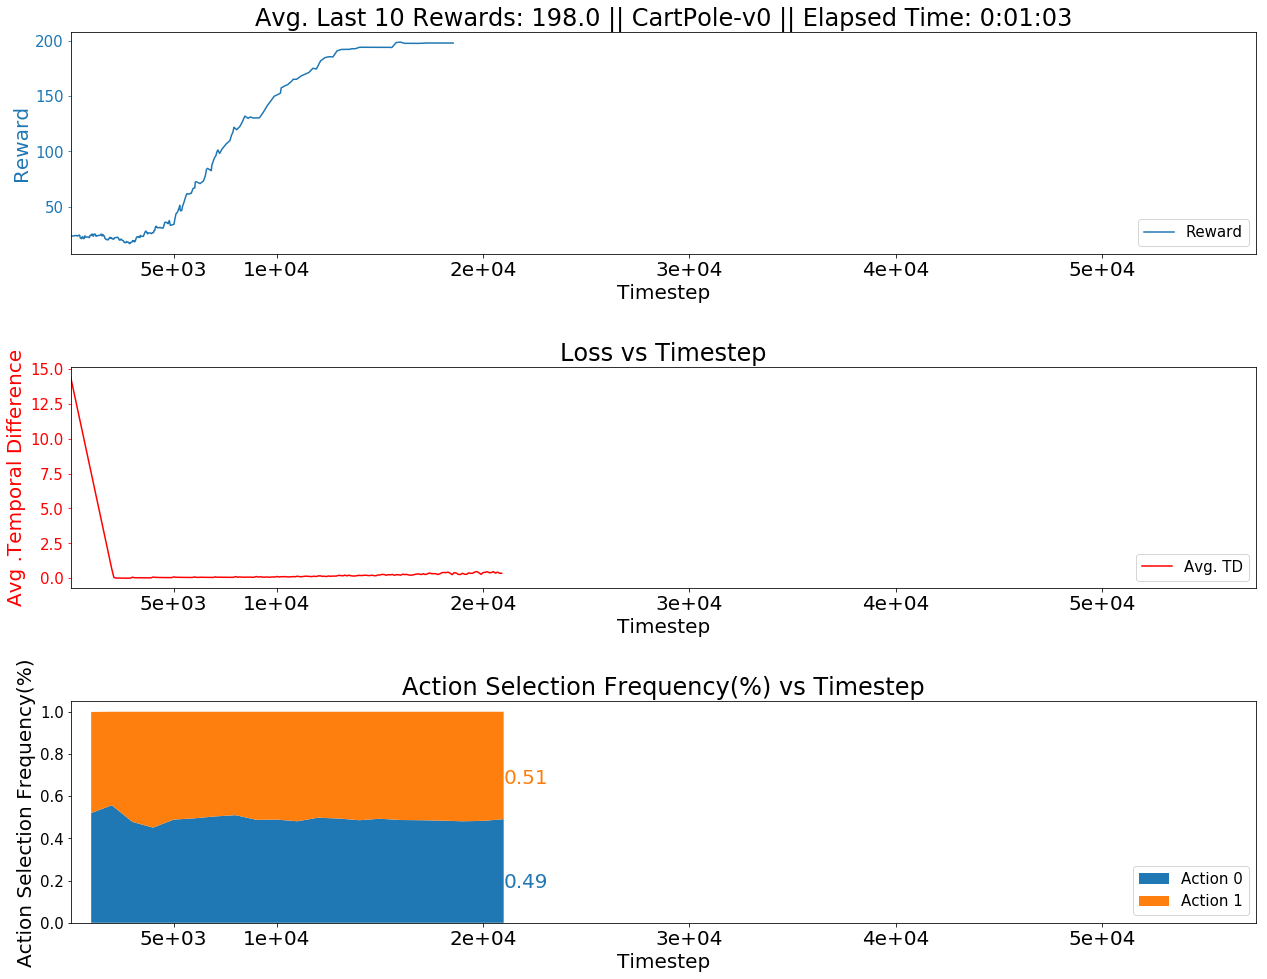

KeyboardInterrupt: 

In [24]:
import gym
from openai_monitor import Monitor
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = 'CartPole-v0'
env    = gym.make(env_id)
env    = Monitor(env, os.path.join(log_dir, env_id))
        
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for sample_idx in range(1, config.MAX_SAMPLES + 1):
    
    epsilon = config.epsilon_by_sample(sample_idx)

    action = model.get_action(observation, epsilon)
    # Log action selection
    model.save_action(action, sample_idx)

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, sample_idx)
    episode_reward += reward

    if done:
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
    if sample_idx % 1000 == 0:
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'DQN', config.MAX_SAMPLES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()

By observing the plots, does the learning appear to be stable?

If your answer is *yes*, then start a second run, and a third, with the same hyperparameters. ;-)

You have just faced reproducibility concerns, which is quite a serious problem in deep RL and which can be dealt with by e.g. running your experiments on a sufficient number of seeds (~ 6-8 min.)

## <font color='#ed7d31'>Visualize the agent</font>

In [25]:
from gym.wrappers import Monitor

# Loading the agent
fname_model = "../saved_agents/model.dump"
fname_optim = "../saved_agents/optim.dump"
log_dir = "/tmp/gym/"

model  = Model(env=env, config=config, log_dir=log_dir)

if os.path.isfile(fname_model):
    model.model.load_state_dict(torch.load(fname_model))
    model.target_model.load_state_dict(model.model.state_dict())

if os.path.isfile(fname_optim):
    model.optimizer.load_state_dict(torch.load(fname_optim))

env_id = 'CartPole-v0'
env    = gym.make(env_id)
env    = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(3):
    done = False
    obs = env.reset()
    while not done:
        action = model.get_action(obs)
        obs, _, done, _ = env.step(action)

env.close()
show_video()

NameError: name 'show_video' is not defined

You can experiment with modifying the hypermarameters (learning rate, batch size, experience replay size, etc.) to see if you can make its performance improve !

-------------